In [9]:
import numpy as np
from sklearn.cluster import KMeans
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string

In [2]:
# Compute inertia and assign labels to closest centroid
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances

def compute_inertia(centroids, data, threshold=100000, distance_metric='euclidean'):
    # Choose distance metric
    if distance_metric == 'euclidean':
        distances = euclidean_distances(data, centroids)
    elif distance_metric == 'manhattan':
        distances = manhattan_distances(data, centroids)
    else:
        raise ValueError("Unsupported distance metric. Choose 'euclidean' or 'manhattan'.")

    labels = np.argmin(distances, axis=1)
    min_distances = np.min(distances, axis=1)

    # Assign -1 for distances greater than threshold
    labels[min_distances > threshold] = -1

    # Compute inertia for assigned data points
    assigned_data_points = data[labels != -1]
    if len(assigned_data_points) > 0:
        assigned_labels = labels[labels != -1]
        inertia = np.sum((assigned_data_points - centroids[assigned_labels]) ** 2)
    else:
        inertia = 0

    # Calculate additional metrics if needed
    num_outliers = np.sum(labels == -1)
    average_distance = np.mean(min_distances[labels != -1]) if len(assigned_data_points) > 0 else 0

    return inertia

In [3]:
class Firefly:
    def __init__(self, data, n_clusters):
        self.position = data[np.random.choice(data.shape[0], n_clusters, replace=False), :]
        self.fitness = compute_inertia(self.position, data)


In [4]:
def firefly_kmeans(data, n_clusters, n_fireflies=10, max_iter=100, alpha=0.5, gamma=1.0):
    fireflies = [Firefly(data, n_clusters) for _ in range(n_fireflies)]

    for _ in range(max_iter):
        fireflies.sort(key=lambda x: x.fitness)
        for i in range(n_fireflies):
            for j in range(n_fireflies):
                if fireflies[j].fitness < fireflies[i].fitness:  # Move i towards j
                    r = np.linalg.norm(fireflies[i].position - fireflies[j].position)
                    beta0 = 1
                    beta = beta0 * np.exp(-gamma * r**2)
                    fireflies[i].position += beta * (fireflies[j].position - fireflies[i].position) + alpha * (np.random.rand(*fireflies[i].position.shape) - 0.5)
                    fireflies[i].fitness = compute_inertia(fireflies[i].position, data)

    best_firefly = fireflies[0]
    final_kmeans = KMeans(n_clusters=n_clusters, init=np.array(best_firefly.position), n_init=1, max_iter=300)
    final_kmeans.fit(data)
    return final_kmeans

In [5]:
newsgroups_dataset = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), random_state=42)

In [6]:
nltk.download('stopwords')
nltk.download('punkt')

# Initialize stopwords, stemmer, and punctuation set
stop_words = set(stopwords.words('english'))
punctuation_set = set(string.punctuation)
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to C:\Users\Devendra
[nltk_data]     Nemade\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Devendra
[nltk_data]     Nemade\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
def preprocess_text(text):
    # Tokenize text
    tokens = word_tokenize(text)
    # Convert to lowercase, remove punctuation, remove stopwords, and stem
    processed_tokens = [stemmer.stem(word.lower()) for word in tokens if word.lower() not in stop_words and word not in punctuation_set]
    # Re-join processed tokens into a single string
    return ' '.join(processed_tokens)

In [10]:
processed_data = [preprocess_text(doc) for doc in newsgroups_dataset.data]
# Use TfidfVectorizer to convert the raw text into TF-IDF features
print("Vectorizing the text data...")
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_data)
n_components = 100
svd = TruncatedSVD(n_components=n_components, random_state=42)
tfidf_matrix_reduced = svd.fit_transform(tfidf_matrix)


Vectorizing the text data...


In [11]:
if tfidf_matrix_reduced.dtype == 'float64':
    tfidf_matrix_reduced = tfidf_matrix_reduced.astype('float32')

In [12]:
n_clusters = 20
kmeans = firefly_kmeans(tfidf_matrix_reduced, n_clusters)
print("Cluster centers:", kmeans.cluster_centers_)
print("Labels:", kmeans.labels_)
#Firefly-Kmeans on 20newsgroups


Cluster centers: [[ 1.30209893e-01  1.12823665e-01  1.23452228e-02 ...  9.89922090e-04
  -4.71026753e-04 -1.38138450e-04]
 [ 1.29268676e-01  1.14607029e-01 -6.22930415e-02 ... -1.63057714e-03
   1.56498398e-03 -3.18326202e-04]
 [ 1.39608055e-01 -5.49166687e-02  2.36984785e-03 ...  7.90554855e-04
   3.56126693e-05 -4.95369313e-05]
 ...
 [ 1.13436662e-01  9.05945990e-03  4.48870771e-02 ... -8.53688340e-04
  -1.19965203e-04 -8.50202981e-04]
 [ 7.18731135e-02 -1.30309351e-02  1.56406667e-02 ... -6.72714366e-03
  -2.81189918e-03  4.04501054e-03]
 [ 1.04575053e-01 -2.90534459e-02  1.17739677e-01 ... -1.26228388e-03
   1.72390311e-04 -4.69854655e-04]]
Labels: [16  4 15 ... 11  3 17]


In [13]:
silhouette = silhouette_score(tfidf_matrix_reduced, kmeans.labels_)
davies_bouldin = davies_bouldin_score(tfidf_matrix_reduced, kmeans.labels_)
calinski_harabasz = calinski_harabasz_score(tfidf_matrix_reduced, kmeans.labels_)
print(f"Silhouette Score: {silhouette}")
print(f"Davies-Bouldin Index: {davies_bouldin}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

Silhouette Score: 0.05936168506741524
Davies-Bouldin Index: 2.774772699484357
Calinski-Harabasz Index: 296.736820581043


In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
Labels_save=[];
for n_clusters in range(2, 21):
    # Run PSO-KMeans with the current number of clusters
    kmeans =  firefly_kmeans(tfidf_matrix_reduced, n_clusters)
    
    # Calculate metrics
    silhouette = silhouette_score(tfidf_matrix_reduced, kmeans.labels_)
    print(silhouette)
    davies_bouldin = davies_bouldin_score(tfidf_matrix_reduced, kmeans.labels_)
    calinski_harabasz = calinski_harabasz_score(tfidf_matrix_reduced, kmeans.labels_)
    
    # Store metrics
    silhouette_scores.append(silhouette)
    davies_bouldin_scores.append(davies_bouldin)
    calinski_harabasz_scores.append(calinski_harabasz)
#     pca = PCA(n_components=2)
#     pca_data = pca.fit_transform(tfidf_matrix_reduced)

# # Visualizing the clusters
#     plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans.labels_)
#     plt.title(f'PCA of KMeans Clusters ({n_clusters} Clusters)')
#     plt.show()

0.08875852
0.09519907
0.029207528
0.086550646
0.058134507
0.09391329
0.068924874
0.07983896
0.064529955
0.04875666
0.06668823
0.07272063
0.064685166
0.04894313
0.05704005
0.050445292
0.0699599
0.04988133
0.057777874


C:\Users\Devendra Nemade\AppData\Local\Temp\ipykernel_15932\1463608575.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Devendra Nemade\AppData\Local\Temp\ipykernel_15932\1463608575.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


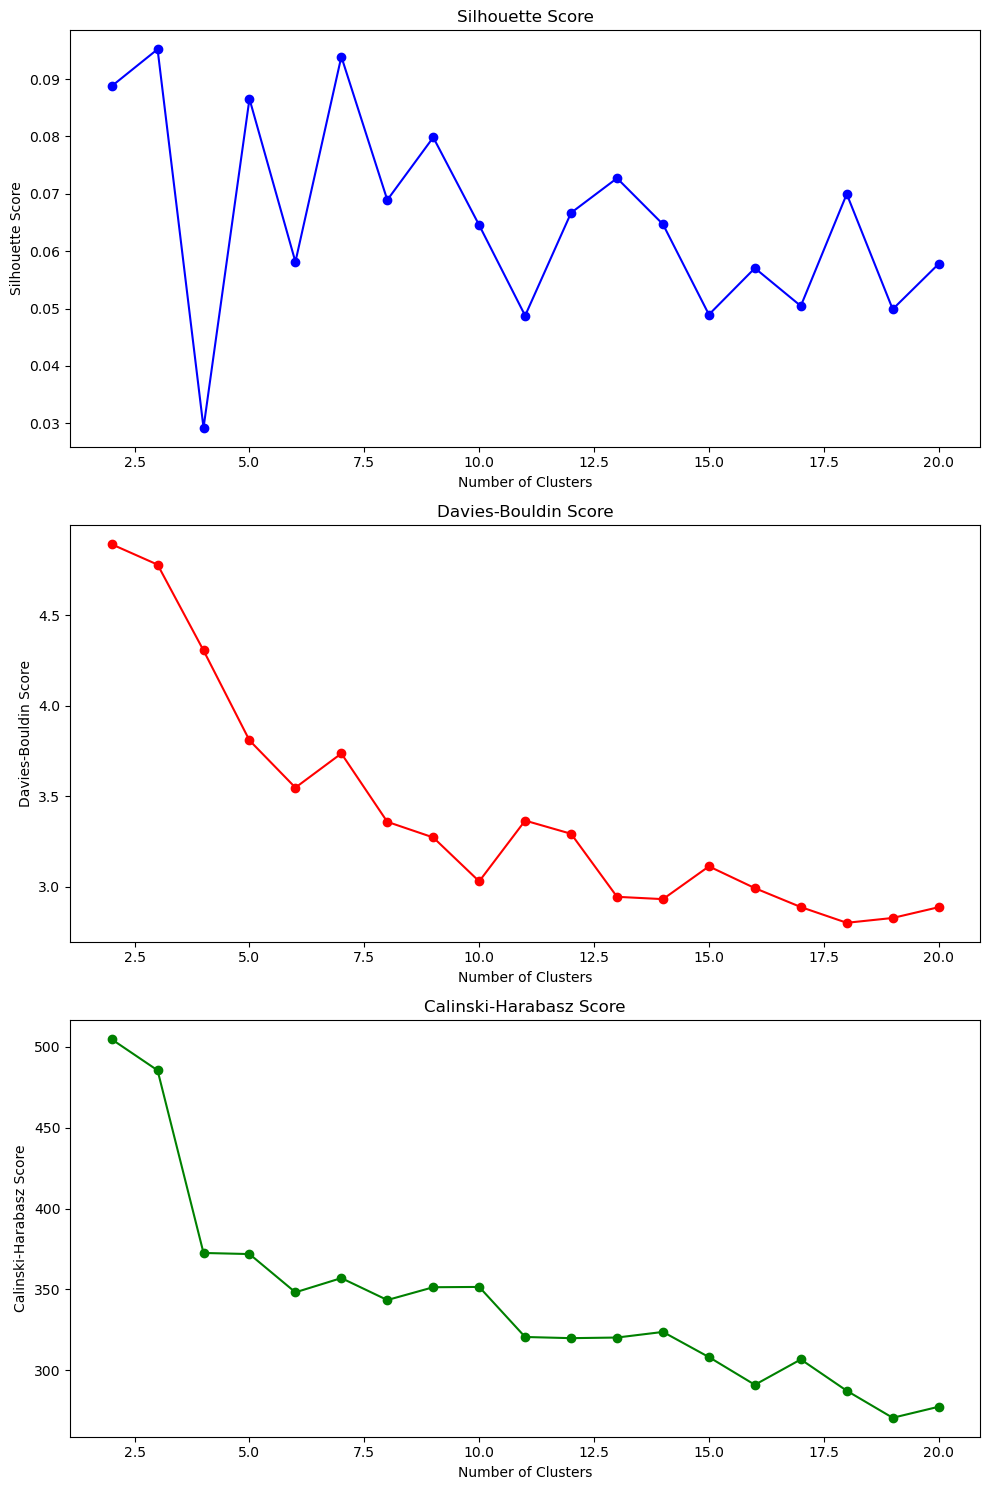

In [16]:
import matplotlib.pyplot as plt
# Plotting the metrics
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Silhouette Score
axs[0].plot(range(2, 21), silhouette_scores, marker='o', linestyle='-', color='blue')
axs[0].set_title('Silhouette Score')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('Silhouette Score')

# Davies-Bouldin Score
axs[1].plot(range(2, 21), davies_bouldin_scores, marker='o', linestyle='-', color='red')
axs[1].set_title('Davies-Bouldin Score')
axs[1].set_xlabel('Number of Clusters')
axs[1].set_ylabel('Davies-Bouldin Score')
plt.tight_layout()
plt.savefig("Davies-Bouldin Score_News_count_firefly-Kmeans.png")
# Calinski-Harabasz Score
axs[2].plot(range(2, 21), calinski_harabasz_scores, marker='o', linestyle='-', color='green')
axs[2].set_title('Calinski-Harabasz Score')
axs[2].set_xlabel('Number of Clusters')
axs[2].set_ylabel('Calinski-Harabasz Score')
plt.tight_layout()
plt.savefig("Calinski-Harabasz Score_News_count_firefly-Kmeans.png")
plt.tight_layout()
plt.show()

In [17]:
import pandas as pd
data = {'Silhouette Score':silhouette_scores,'davies_bouldin_scores': davies_bouldin_scores,
        'calinski_harabasz_scores': calinski_harabasz_scores}
df=pd.DataFrame(data,index=range(2, 21))
df

,Silhouette Score,davies_bouldin_scores,calinski_harabasz_scores
2,0.088759,4.892879,504.744001
3,0.095199,4.780328,485.517464
4,0.029208,4.306382,372.513435
5,0.086551,3.809462,371.831233
6,0.058135,3.548625,348.158091
7,0.093913,3.737158,356.958567
8,0.068925,3.359654,343.384831
9,0.079839,3.273358,351.306619
10,0.064530,3.030933,351.493135
11,0.048757,3.366482,320.519957


In [18]:
df.to_csv('News_TFIDF_FIREFLY-Kmeans.csv')